In [1]:
import os
os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = '1'

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline
import time
import os

In [3]:
device=torch.device('mps')

In [4]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:8])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']


In [5]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [6]:
# shuffle up the words
import random
random.seed(42)
random.shuffle(words)

In [7]:
# build the dataset
block_size = 15 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] # crop and append

  X = torch.tensor(X).to(device=device)
  Y = torch.tensor(Y).to(device=device)
  print(X.shape, Y.shape)
  return X, Y

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])  # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([182625, 15]) torch.Size([182625])
torch.Size([22655, 15]) torch.Size([22655])
torch.Size([22866, 15]) torch.Size([22866])


In [8]:
class Linear:
  
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), device=device) / fan_in**0.5 # note: kaiming init
    self.bias = torch.zeros(fan_out, device=device) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# -----------------------------------------------------------------------------------------------
class BatchNorm1d:
  
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True
    # Parameters (trainable via backprop)
    self.gamma = torch.ones(dim, device=device).view(1, -1, 1)  # Shape [1, C, 1]
    self.beta = torch.zeros(dim, device=device).view(1, -1, 1)  # Shape [1, C, 1]
    # Buffers (updated via momentum)
    self.running_mean = torch.zeros(dim, device=device)  # Shape [C]
    self.running_var = torch.ones(dim, device=device)    # Shape [C]
  
  def __call__(self, x):
    if self.training:
      # Compute mean and variance across batch and sequence length (dim=(0,2))
      xmean = x.mean(dim=(0, 2), keepdim=True)  # Shape [1, C, 1]
      xvar = x.var(dim=(0, 2), keepdim=True)    # Shape [1, C, 1]
    else:
      # Use running statistics for inference
      xmean = self.running_mean.view(1, -1, 1)  # Shape [1, C, 1]
      xvar = self.running_var.view(1, -1, 1)    # Shape [1, C, 1]
    
    # Normalize input
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)  # Normalize to unit variance
    self.out = self.gamma * xhat + self.beta         # Scale and shift

    # Update running statistics during training
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean.squeeze()
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar.squeeze()
    
    return self.out
  
  def parameters(self):
    # Return trainable parameters
    return [self.gamma, self.beta]


# -----------------------------------------------------------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# -----------------------------------------------------------------------------------------------
class Embedding:
  
  def __init__(self, num_embeddings, embedding_dim):
    self.weight = torch.randn((num_embeddings, embedding_dim), device=device)
    
  def __call__(self, IX):
    self.out = self.weight[IX].transpose(1, 2)
    
    return self.out
  
  def parameters(self):
    return [self.weight]

# -----------------------------------------------------------------------------------------------
class FlattenConsecutive:
  
  def __init__(self, n):
    self.n = n
    
  def __call__(self, x):
    B, T, C = x.shape
    x = x.view(B, T//self.n, C*self.n)
    if x.shape[1] == 1:
      x = x.squeeze(1)
    self.out = x
    return self.out
  
  def parameters(self):
    return []

class Flatten:
    def __call__(self, x):
        self.out = x.view(x.shape[0], -1)
        return self.out
    def parameters(self):
        return []

# -----------------------------------------------------------------------------------------------
class Sequential:
  
  def __init__(self, layers):
    self.layers = layers
  
  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    self.out = x
    return self.out
  
  def parameters(self):
    # get parameters of all layers and stretch them out into one list
    return [p for layer in self.layers for p in layer.parameters()]

# --------------------------------------------
class Conv1d:
    def __init__(self, sequence_length, in_channels, out_channels, kernel=2, stride=1, dilation=1):
        self. sequence_length = sequence_length
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel = kernel
        self.stride = stride
        self.dilation = dilation
        self.filters = torch.randn((out_channels, in_channels, kernel), device=device) * ((2 / (in_channels * kernel)) ** 0.5)
        self.bias = torch.randn(out_channels, device=device) * 0
        self.effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        self.Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
    def __call__(self, x):
        # Compute effective kernel size based on dilation 
        # effective_kernel = ((self.kernel - 1) * self.dilation) + 1
        
        N, C, L = x.shape
        assert self.effective_kernel <= L
            
        # create the sliding windows of the input
        
        x_unfolded = x.unfold(2, self.effective_kernel, self.stride)

        # Extract dilated inputs from x_unfolded which used effective_kernel. The shape of the unfolded vector is [N, C, L, effective_k] 
        # where L is the length of the sequence depending on the effective kernel. From the dimension of effective_kernel, we clip every 'dilated' index
        # If effective_kernel is 3 and dilation is 2, [1, 2, 3] will result in [1, 3]. [1,3] has length of 2, which is equal to actual kernel value
        x_unfolded = x_unfolded[:, :, :, ::self.dilation]

        # The dilation also changes the sequence length, since effective kernel value changes with dilation > 1. 
        # Compute Lout based on effective_kernel
        
        # Lout = ((self.sequence_length - self.effective_kernel) // self.stride) + 1
        
        # Before cross correlation, we need to broadcast the filters and the input correctly
        x_unfolded = x_unfolded.view(N, 1, C, self.Lout, self.kernel)
        filters = self.filters.view(1, self.out_channels, self.in_channels, 1, self.kernel)

        # Perform element wise multiplication
        self.out = torch.mul(x_unfolded, filters).sum((2, 4)) + self.bias.view(1, self.out_channels, 1)
        return self.out        
    
    def parameters(self): 
        return [self.filters] + [self.bias]

class ReLu: 
    def __call__(self, x):
        self.out = torch.relu(x)
        return self.out

    def parameters(self):
        return []
        
class Transpose:
    def __call__(self, x):
        self.out = x.transpose(1, 2)
        return self.out
    
    def parameters(self):
        return []

class Residual: 
    def __init__(self, layers):
        self.projection_needed = False
        self.layers = layers
        
        
        # Input of the in layer config
        in_layer = layers[0]
        out_layer = layers[-1]

        self.in_channels = in_layer.in_channels
        self.in_sequence_length = in_layer.sequence_length

        self.out_channels = out_layer.out_channels
        self.out_sequence_length = out_layer.Lout

        if self.in_channels != self.out_channels: # Assuming for now, this will always be the case
            self.projection_needed = True
            self.linear_projection_conv = Conv1d(sequence_length=self.in_sequence_length, out_channels=self.out_channels, in_channels=self.in_channels, kernel=1)
            
    def __call__(self, x):
        self.input = x
        for layer in self.layers: 
            x = layer(x)
        # Perform residual operation
        if self.projection_needed:
            linear_projection = self.linear_projection_conv(self.input)
            
        # Pad the output since the Lout != Lin
        sequence_length_diff = self.in_sequence_length - self.out_sequence_length
        x = F.pad(x, (sequence_length_diff // 2, sequence_length_diff - sequence_length_diff // 2))
        
        self.out = x + linear_projection if self.projection_needed else x + self.input
        
        return self.out
        
    def parameters(self):
        # Collect parameters from all layers and the projection (if used)
        params = [p for layer in self.layers for p in layer.parameters()]
        if self.projection_needed:
            params += self.linear_projection_conv.parameters()
        return params

In [18]:
def get_Lout(sequence_length, kernel, dilation, stride):
    effective_kernel = (kernel - 1) * dilation + 1
    Lout = ((sequence_length - effective_kernel) // stride) + 1
    return Lout
    
### Let's redefine the model with conv layers 
n_embedding = 24

# Residual Layer 1:
# Downsample to 4
res1_down_out_channels = 15
res1_down_stride = 1 
res1_down_kernel = 1
res1_down_dilation = 1
res1_down_Lout = get_Lout(block_size, res1_down_kernel, res1_down_dilation, res1_down_stride)

# Conv1d for feature extraction 
res1_conv_out_channels = 15
res1_conv_stride = 1 
res1_conv_kernel = 2
res1_conv_dilation = 1
res1_conv_Lout = get_Lout(res1_down_Lout, res1_conv_kernel, res1_conv_dilation, res1_conv_stride)
# Upsample to 10
res1_up_out_channels = 24
res1_up_stride = 1 
res1_up_kernel = 1
res1_up_dilation = 1
res1_up_Lout = get_Lout(res1_conv_Lout, res1_up_kernel, res1_up_dilation, res1_up_stride)

# Upsampling Layer 1x1 conv to scale to 40
up_1_out_channels = 40
up_1_stride = 1 
up_1_kernel = 1
up_1_dilation = 1
up_1_Lout = get_Lout(block_size, up_1_kernel, up_1_dilation, up_1_stride)


# Residual Layer 2:
# Downsample to 4
res2_down_out_channels = 15
res2_down_stride = 1 
res2_down_kernel = 1
res2_down_dilation = 1
res2_down_Lout = get_Lout(up_1_Lout, res2_down_kernel, res2_down_dilation, res2_down_stride)
# Conv1d for feature extraction 
res2_conv_out_channels = 15
res2_conv_stride = 1 
res2_conv_kernel = 2
res2_conv_dilation = 1
res2_conv_Lout = get_Lout(res2_down_Lout, res2_conv_kernel, res2_conv_dilation, res2_conv_stride)
# Upsample to 10
res2_up_out_channels = 40
res2_up_stride = 1 
res2_up_kernel = 1
res2_up_dilation = 1
res2_up_Lout = get_Lout(res2_conv_Lout, res2_up_kernel, res2_up_dilation, res2_up_stride)

# Upsampling Layer and 2 kernel conv to scale to 60
up_2_out_channels = 60
up_2_stride = 1 
up_2_kernel = 1
up_2_dilation = 1
up_2_Lout = get_Lout(block_size, up_2_kernel, up_2_dilation, up_2_stride)

# # Residual Layer 3:
# Downsample 
res3_down_out_channels = 30
res3_down_stride = 1 
res3_down_kernel = 1
res3_down_dilation = 1
res3_down_Lout = get_Lout(up_2_Lout, res3_down_kernel, res3_down_dilation, res3_down_stride)
# Conv1d for feature extraction 
res3_conv_out_channels = 30
res3_conv_stride = 1 
res3_conv_kernel = 3
res3_conv_dilation = 2
res3_conv_Lout = get_Lout(res3_down_Lout, res3_conv_kernel, res3_conv_dilation, res3_conv_stride)
# Upsample
res3_up_out_channels = 60
res3_up_stride = 1 
res3_up_kernel = 1
res3_up_dilation = 1
res3_up_Lout = get_Lout(res3_conv_Lout, res3_down_kernel, res3_down_dilation, res3_down_stride)


## Note: Remember that each residual layer restores the sequence length Lout to the actual sequence length (block_size), 
# due to padding and adding input to the output. Hence, commenting the Lout computation out below.


#h1
n_h1_fanout = 100

#h2
n_h2_fanout = 100

model = Sequential([
    Embedding(vocab_size, n_embedding), 

    Residual([
        Conv1d(
                sequence_length=block_size,
                in_channels=n_embedding,
                out_channels=res1_down_out_channels,
                kernel=1,
            ),
    
        # Conv Layer
        Conv1d(
                    sequence_length=res1_down_Lout,
                    in_channels=res1_down_out_channels,
                    out_channels=res1_conv_out_channels,
                    kernel=2,
                ),
        # Upsample 
        Conv1d(
                    sequence_length=res1_conv_Lout,
                    in_channels=res1_conv_out_channels,
                    out_channels=res1_up_out_channels,
                    kernel=1,
                ),
    ]),
    
    BatchNorm1d(res1_up_out_channels),
    ReLu(),
    # Up sample to 40 channels
    Conv1d(
            sequence_length=block_size,
            in_channels=res1_up_out_channels,
            out_channels=up_1_out_channels,
            kernel=1,
        ),
    ReLu(),

    Residual([
        Conv1d(
            sequence_length=block_size,
            in_channels=up_1_out_channels,
            out_channels=res2_down_out_channels,
            kernel=1,
        ), 
        # Conv 
        Conv1d(
                    sequence_length=block_size,
                    in_channels=res2_down_out_channels,
                    out_channels=res2_conv_out_channels,
                    kernel=res2_conv_kernel,
                ),
        # Up sample
        Conv1d(
                    sequence_length=res2_conv_Lout,
                    in_channels=res2_conv_out_channels,
                    out_channels=res2_up_out_channels,
                    kernel=1,
                ),
    ]),
    BatchNorm1d(res2_up_out_channels),
    ReLu(), 
    
    Conv1d(
                sequence_length=block_size,
                in_channels=res2_up_out_channels,
                out_channels=up_2_out_channels,
                kernel=up_2_kernel,
            ),

    # 3rd residual layer
        Residual([
        Conv1d(
                sequence_length=up_2_Lout,
                in_channels=up_2_out_channels,
                out_channels=res3_down_out_channels,
                kernel=1,
            ),
    
        # Conv Layer
        Conv1d(
                    sequence_length=res3_down_Lout,
                    in_channels=res3_down_out_channels,
                    out_channels=res3_conv_out_channels,
                    kernel=res3_conv_kernel,
                    dilation=res3_conv_dilation,
                ),
        # Upsample 
        Conv1d(
                    sequence_length=res3_conv_Lout,
                    in_channels=res3_conv_out_channels,
                    out_channels=res3_up_out_channels,
                    kernel=1,
                ),
    ]),
    
    BatchNorm1d(res3_up_out_channels),
    ReLu(),

            # Up sample
    Conv1d(
                sequence_length=block_size,
                in_channels=60,
                out_channels=100,
                kernel=1,
            ),

    Conv1d(
            sequence_length=block_size,
            in_channels=100,
            out_channels=100,
            kernel=2,
         ),
    
    # Output of residual will be the [out_channels, input_sequence_length of the layer before the residual layer]
    Flatten(), Linear(fan_in=14 * 100, fan_out=n_h1_fanout), Tanh(),
    Linear(fan_in=n_h1_fanout, fan_out=vocab_size)
])



with torch.no_grad():
    model.layers[-1].weight *= 0.1

# parameters = [p for layer in layers for p in layer.parameters()]
print(f"parameters: {sum(p.nelement() for p in model.parameters())}")

for p in model.parameters():
    p.requires_grad = True

parameters: 182747


In [19]:
lossi = []

In [20]:
# same optimization as last time
max_steps = 400_000
batch_size = 32
start_time = time.time_ns()
ud = []
for i in range(max_steps):
  
  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] # batch X,Y

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb) # loss function
  
  for p in model.parameters():
    p.grad = None
  loss.backward()
  
  # update
  lr = 0.001 if i < 200_000 else 0.0001 # step learning rate decay
  for p in model.parameters():
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0: # print every once in a while
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

end_time = time.time_ns()
print(f"time taken to train: {(end_time - start_time) // 1_000_000_000}")

      0/ 400000: 3.3081
  10000/ 400000: 2.4251
  20000/ 400000: 2.1648
  30000/ 400000: 2.5118
  40000/ 400000: 2.4760
  50000/ 400000: 2.4867
  60000/ 400000: 2.0067
  70000/ 400000: 2.1047
  80000/ 400000: 2.1649
  90000/ 400000: 2.1224
 100000/ 400000: 2.3246
 110000/ 400000: 2.4448
 120000/ 400000: 2.4239
 130000/ 400000: 2.4486
 140000/ 400000: 2.0783
 150000/ 400000: 1.9888
 160000/ 400000: 1.7761
 170000/ 400000: 2.1973
 180000/ 400000: 2.0770
 190000/ 400000: 2.3408
 200000/ 400000: 2.1980
 210000/ 400000: 1.9505
 220000/ 400000: 2.1830
 230000/ 400000: 1.8944
 240000/ 400000: 1.7944
 250000/ 400000: 1.8862
 260000/ 400000: 2.1328
 270000/ 400000: 2.1485
 280000/ 400000: 1.8166
 290000/ 400000: 1.9412
 300000/ 400000: 1.7596
 310000/ 400000: 2.0998
 320000/ 400000: 1.8884
 330000/ 400000: 2.0617
 340000/ 400000: 2.1394
 350000/ 400000: 1.9980
 360000/ 400000: 2.3023
 370000/ 400000: 2.0255
 380000/ 400000: 2.2321
 390000/ 400000: 2.2607
time taken to train: 9514


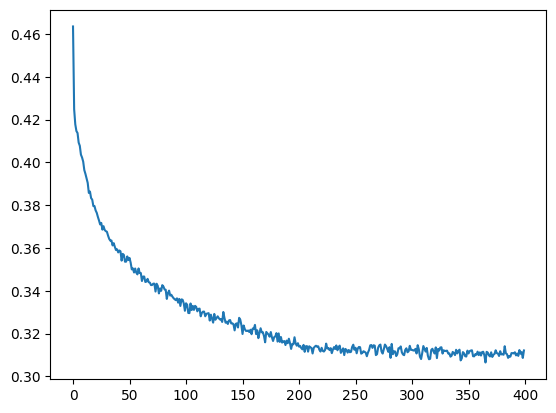

In [21]:
plt.plot(torch.tensor(lossi).view(-1, 1000).mean(1))


In [38]:
@torch.no_grad() # this decorator disables gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x[:2000])
  
  loss = F.cross_entropy(logits, y[:2000])
  print(split, loss.item())

In [39]:
for layer in model.layers:
    layer.training = False
    
# split_loss('train')
split_loss('val')

val 2.094306468963623
